 
 ## FinSight - Sistema de Prevenção ao Rotativo no Cartão de Crédito
 
 ### Geração de Base Sintética para Modelo Preditivo


#### OBJETIVO DO CASE: 
Desenvolver um modelo de machine learning que antecipe quando clientes "bons" (estáveis) podem entrar em rotativo no cartão de crédito devido a eventos  de estresse financeiro.

#### PROBLEMA DE NEGÓCIO:
Clientes historicamente bons que passam por dificuldades financeiras começam a usar rotativo, gerando prejuízos para o banco e risco de inadimplência.

#### SOLUÇÃO PROPOSTA:
Criar uma base sintética realista que simule 3 perfis de clientes e treinar um modelo para identificar sinais precoces de estresse.

In [ ]:
# =============================================================================
#  BLOCO ÚNICO: SIMULAÇÃO, FEATURE ENGINEERING E MODELAGEM LIGHTGBM
# =============================================================================

# -----------------------------------------------------------------------------
#  IMPORTAÇÕES E CONFIGURAÇÃO
# -----------------------------------------------------------------------------
import pandas as pd
import numpy as np
import datetime
import warnings
from lightgbm import LGBMClassifier, early_stopping 
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix
import pickle
import sys

# Ignora warnings para um output mais limpo
warnings.filterwarnings('ignore')
print(" Bibliotecas importadas com sucesso!")

# =============================================================================
#  CONFIGURAÇÃO DA SIMULAÇÃO - PARÂMETROS GLOBAIS
# =============================================================================
N_CLIENTES = 10000       # Número de clientes para simular
N_MESES = 24             # Histórico de 24 meses (2 anos)
MES_INICIO_ALERTA = 16   # Mês em que o sinal de alto uso/dívida começa
MES_INICIO_ROTATIVO = 18 # Mês em que o evento-alvo (Rotativo) acontece
PCT_ESTRESSE = 0.20      # % de clientes bons que sofrerão estresse

# PONTO CRUCIAL PARA O DATA SPLITTING NO BLOCO DE MODELAGEM
MES_INICIO_ESTRESSE = MES_INICIO_ROTATIVO # Define o ponto de corte do treino/teste

# Probabilidades demográficas baseadas em dados reais (Serasa & ANBIMA)
PROB_IDADE = [0.113, 0.338, 0.354, 0.195]       
PROB_CLASSE = [0.24, 0.47, 0.29]                
PROB_REGIAO = [0.43, 0.26, 0.15, 0.08, 0.08]    

print(f" Iniciando simulação para {N_CLIENTES} clientes em {N_MESES} meses...")

# -----------------------------------------------------------------------------
# 1. FUNÇÕES DE SIMULAÇÃO (Criar Clientes Estáticos)
# -----------------------------------------------------------------------------
def criar_clientes_estaticos(n_clientes):    
    """ Cria a base inicial de clientes com perfis demográficos e financeiros. """
    df_clientes = pd.DataFrame(
        index=np.arange(1, n_clientes + 1),
        columns=[
            'id_cliente', 'idade_faixa', 'classe_social', 'regiao', 
            'perfil_investidor', 'limite_cartao', 'scr_divida_inicial', 
            'grupo_simulacao'
        ]
    )
    df_clientes['id_cliente'] = np.arange(1, n_clientes + 1)
    df_clientes['idade_faixa'] = np.random.choice(['18-25', '26-40', '41-65', '65+'], n_clientes, p=PROB_IDADE)
    df_clientes['classe_social'] = np.random.choice(['A/B', 'C', 'D/E'], n_clientes, p=PROB_CLASSE)
    df_clientes['regiao'] = np.random.choice(['Sudeste', 'Nordeste', 'Sul', 'Norte', 'Centro-Oeste'], n_clientes, p=PROB_REGIAO)
    
    probs_perfil = {'A/B': [0.36, 0.22, 0.13, 0.29], 'C': [0.13, 0.22, 0.15, 0.50], 'D/E': [0.05, 0.15, 0.09, 0.71]}
    df_clientes['perfil_investidor'] = df_clientes['classe_social'].apply(
        lambda x: np.random.choice(['Diversifica', 'Caderneta', 'Economiza', 'Sem Reserva'], p=probs_perfil[x])
    )
    
    limites = {'A/B': (10000, 30000), 'C': (3000, 10000), 'D/E': (500, 3000)}
    dividas = {'A/B': (1000, 5000), 'C': (500, 2000), 'D/E': (0, 500)}
    df_clientes['limite_cartao'] = df_clientes['classe_social'].apply(lambda x: np.random.uniform(*limites[x]))
    df_clientes['scr_divida_inicial'] = df_clientes['classe_social'].apply(lambda x: np.random.uniform(*dividas[x]))

    def definir_grupo(row):
        if row['perfil_investidor'] in ['Sem Reserva', 'Economiza']:
            return 'instavel'
        else:
            if np.random.rand() < PCT_ESTRESSE:
                return 'estavel_target'
            else:
                return 'estavel_controle'
                
    df_clientes['grupo_simulacao'] = df_clientes.apply(definir_grupo, axis=1)
    
    print(" Perfis estáticos criados.")
    return df_clientes.set_index('id_cliente')

# -----------------------------------------------------------------------------
# 2. FUNÇÕES DE SIMULAÇÃO (Carregar Dados Macro - Mock para a célula única)
# -----------------------------------------------------------------------------
def carregar_dados_macro():    
    """
    Simula o carregamento de dados macroeconômicos (BC) para rodar em célula única.
    Retorna um DataFrame mock se os arquivos não forem encontrados.
    """
    try:
        # Tenta carregar os arquivos reais (se existirem no ambiente)
        df_rotativo = pd.read_csv('bcdata.sgs.20679.csv', sep=';', decimal=',', parse_dates=['data'], dayfirst=True)
        df_pessoal = pd.read_csv('bcdata.sgs.20665.csv', sep=';', decimal=',', parse_dates=['data'], dayfirst=True)
        df_inadimp = pd.read_csv('bcdata.sgs.21084.csv', sep=';', decimal=',', parse_dates=['data'], dayfirst=True)
        
        df_macro = df_rotativo[['data', 'valor']].rename(columns={'valor': 'taxa_juros_rotativo'})
        df_macro['taxa_juros_pessoal'] = df_pessoal['valor']
        df_macro['taxa_inadimplencia_pf'] = df_inadimp['valor']
        
        df_macro = df_macro.sort_values('data').reset_index(drop=True).tail(N_MESES).reset_index(drop=True)
        df_macro['mes_simulacao'] = np.arange(1, N_MESES + 1)
        
        print(f" Dados macro carregados. Último mês: {df_macro['data'].max().date()}")
        return df_macro[['mes_simulacao', 'taxa_juros_rotativo', 'taxa_juros_pessoal', 'taxa_inadimplencia_pf']]

    except:
        print(" Arquivos CSV do Banco Central não encontrados. Usando dados mock para simulação.")
        
        # Cria um DataFrame mock se os arquivos não existirem
        df_macro_mock = pd.DataFrame({
            'mes_simulacao': np.arange(1, N_MESES + 1),
            # Valores realistas para as simulações
            'taxa_juros_rotativo': np.random.uniform(3.5, 4.5, N_MESES), 
            'taxa_juros_pessoal': np.random.uniform(0.15, 0.25, N_MESES),
            'taxa_inadimplencia_pf': np.random.uniform(0.035, 0.055, N_MESES)
        })
        return df_macro_mock

# -----------------------------------------------------------------------------
# 3. FUNÇÕES DE SIMULAÇÃO (Gerar Histórico Longitudinal)
# -----------------------------------------------------------------------------

def gerar_historico_longitudinal(df_clientes, df_macro):    
    """ Cria histórico de transações mês a mês com lógica de estresse. """
    historico_total = []
    datas_mes = pd.date_range(end=datetime.date.today(), periods=N_MESES, freq='MS')
    
    for id_cliente, perfil in df_clientes.iterrows():
        grupo = perfil['grupo_simulacao']
        limite = perfil['limite_cartao']
        divida_scr_atual = perfil['scr_divida_inicial']
        
        for mes_num in range(1, N_MESES + 1):
            gasto_cartao = 0
            pagamento_fatura = 0
            flag_rotativo = False
            
            # Comportamento: Instável (Ruim desde o início)
            if grupo == 'instavel':
                gasto_cartao = limite * np.random.uniform(0.5, 1.0)
                if np.random.rand() < 0.3:
                    pagamento_fatura = gasto_cartao * np.random.uniform(0.15, 0.5)
                    flag_rotativo = True
                else:
                    pagamento_fatura = gasto_cartao
                divida_scr_atual *= np.random.uniform(0.95, 1.1)

            # Comportamento: Estável (Bom, sem stress)
            elif grupo == 'estavel_controle':
                gasto_cartao = limite * np.random.uniform(0.2, 0.5)
                pagamento_fatura = gasto_cartao
                flag_rotativo = False
                divida_scr_atual *= np.random.uniform(0.98, 1.02)
                
            # Comportamento: Target (Bom, mas sofre estresse)
            elif grupo == 'estavel_target':
                if mes_num < MES_INICIO_ALERTA:
                    # FASE 1: Comportamento Normal (Meses < 16)
                    gasto_cartao = limite * np.random.uniform(0.2, 0.5)
                    pagamento_fatura = gasto_cartao
                    flag_rotativo = False
                    divida_scr_atual *= np.random.uniform(0.98, 1.02)
                
                elif mes_num < MES_INICIO_ROTATIVO:
                    # FASE 2: SINAL MODERADO / FORTE (Meses 16 e 17)
                    gasto_cartao = limite * np.random.uniform(0.8, 1.0) 
                    pagamento_fatura = gasto_cartao # Paga integralmente (ainda não entrou no rotativo)
                    flag_rotativo = False
                    
                    if mes_num == MES_INICIO_ALERTA:
                        divida_scr_atual *= np.random.uniform(1.2, 1.4)
                    else:
                        divida_scr_atual *= np.random.uniform(1.5, 2.0)
                
                else:
                    # FASE 3: ESTRESSE TOTAL (Mês 18+) - EVENTO ALVO
                    gasto_cartao = limite * np.random.uniform(0.8, 1.1)
                    divida_scr_atual *= np.random.uniform(1.1, 1.4)
                    pagamento_fatura = gasto_cartao * np.random.uniform(0.15, 0.3)
                    flag_rotativo = True
            
            historico_total.append({
                'id_cliente': id_cliente,
                'mes_referencia': datas_mes[mes_num-1],
                'mes_simulacao': mes_num,
                'gasto_total_cartao': gasto_cartao,
                'pagamento_fatura': pagamento_fatura,
                'utilizacao_limite_cartao': gasto_cartao / limite,
                'flag_rotativo': flag_rotativo,
                'scr_saldo_devedor_total': divida_scr_atual
            })
            
    df_hist = pd.DataFrame(historico_total)
    
    if df_macro is not None:
        df_hist = df_hist.merge(df_macro, on='mes_simulacao', how='left')
        
    return df_hist.merge(df_clientes, on='id_cliente', how='left')

# -----------------------------------------------------------------------------
# 4. FUNÇÕES DE SIMULAÇÃO (Feature Engineering)
# -----------------------------------------------------------------------------

def criar_features_janeladas(df):    
    """ Cria features de tendência (últimos 3 meses) que o modelo usará. """
    print(" Criando features de janela móvel (tendência)...")
    
    df = df.sort_values(['id_cliente', 'mes_referencia'])
    g = df.groupby('id_cliente')
    
    # 1. Taxa de Comprometimento de Renda Implícita (TCRI)
    FATOR_RENDA = 5
    df['scr_tcr_implicita'] = df['scr_saldo_devedor_total'].shift(1) / (df['limite_cartao'] * FATOR_RENDA)
    
    # 2. Aumento no uso do cartão de crédito (Tendência)
    gasto_media_3m = g['gasto_total_cartao'].rolling(window=3, min_periods=1).mean().shift(1).reset_index(level=0, drop=True)
    gasto_ult_mes = g['gasto_total_cartao'].shift(1).reset_index(level=0, drop=True)
    df['gasto_crescim_3m'] = (gasto_ult_mes / gasto_media_3m) - 1
    
    # 3. Aumento do endividamento no SCR (Tendência)
    scr_media_3m = g['scr_saldo_devedor_total'].rolling(window=3, min_periods=1).mean().shift(1).reset_index(level=0, drop=True)
    scr_ult_mes = g['scr_saldo_devedor_total'].shift(1).reset_index(level=0, drop=True)
    df['scr_crescim_divida_3m'] = (scr_ult_mes / scr_media_3m) - 1
    
    # --- Outras features de suporte importantes ---
    df['utilizacao_limite_media_3m'] = g['utilizacao_limite_cartao'].rolling(window=3, min_periods=1).mean().shift(1).reset_index(level=0, drop=True)
    df['contagem_rotativo_3m'] = g['flag_rotativo'].rolling(window=3, min_periods=1).sum().shift(1).reset_index(level=0, drop=True)

    df = df.fillna(0)
    df = df.replace([np.inf, -np.inf], 0)
    
    return df

# -----------------------------------------------------------------------------
# 5. FUNÇÕES DE SIMULAÇÃO (Criar Variável Alvo)
# -----------------------------------------------------------------------------

def criar_variavel_alvo(df):    
    """ Cria a coluna 'target' que o modelo de ML tentará prever. """
    print(" Criando variável alvo...")
    df = df.sort_values(['id_cliente', 'mes_referencia'])
    # O target é se o cliente entra no rotativo NO PRÓXIMO MÊS
    df['entrou_rotativo_proximo_mes'] = df.groupby('id_cliente')['flag_rotativo'].shift(-1)
    df_ml = df.dropna(subset=['entrou_rotativo_proximo_mes'])
    df_ml['entrou_rotativo_proximo_mes'] = df_ml['entrou_rotativo_proximo_mes'].astype(int)
    
    print(f"   [Base Final ML]: {len(df_ml)} registros de observação criados.")
    target_dist = df_ml['entrou_rotativo_proximo_mes'].value_counts(normalize=True).sort_index()
    print(f"   [Desbalanceamento do Target]: Classe 0 = {target_dist[0]:.2%}, Classe 1 = {target_dist[1]:.2%}")
    return df_ml

# -----------------------------------------------------------------------------
# 6. FUNÇÃO PRINCIPAL DA SIMULAÇÃO
# -----------------------------------------------------------------------------

def main_simulacao():    
    """ FLUXO PRINCIPAL DA SIMULAÇÃO: Cria a base e salva o arquivo. """
    df_clientes = criar_clientes_estaticos(N_CLIENTES)
    df_macro = carregar_dados_macro()
    df_historico_completo = gerar_historico_longitudinal(df_clientes, df_macro)
    df_features = criar_features_janeladas(df_historico_completo)
    df_base_ml = criar_variavel_alvo(df_features)

    print(f"\n Salvando base de ML final...")
    try:
        df_base_ml.to_parquet('base_simulada_clientes.parquet', index=False)
        print(" Sucesso! Base salva em 'base_simulada_clientes.parquet'")
    except ImportError:
        df_base_ml.to_csv('base_simulada_clientes.csv', index=False, sep=';', decimal=',')
        print(" Sucesso! Base salva em 'base_simulada_clientes.csv' (Parquet indisponível)")
        
    return df_base_ml

# =============================================================================
#  EXECUÇÃO DA SIMULAÇÃO E PREPARAÇÃO DO DATAFRAME EM MEMÓRIA
# =============================================================================

# Executa a simulação e armazena o DataFrame final na memória
df_base_ml = main_simulacao()


# -----------------------------------------------------------------------------
# 7. DEFINIÇÃO DE FEATURES PARA MODELAGEM
# -----------------------------------------------------------------------------

TARGET = 'entrou_rotativo_proximo_mes'
FEATURES_CATEGORICAS = ['idade_faixa', 'classe_social', 'regiao']
FEATURES_NUMERICAS = [
    'limite_cartao',  
    'scr_tcr_implicita',              
    'gasto_crescim_3m',               
    'scr_crescim_divida_3m',            
    'utilizacao_limite_media_3m',     
    'contagem_rotativo_3m'           
]

# -----------------------------------------------------------------------------
# 8. PREPARAÇÃO DA BASE DE DADOS (OHE)
# -----------------------------------------------------------------------------

print("\nIniciando pré-processamento (One-Hot Encoding)...")
df_final = pd.get_dummies(df_base_ml, columns=FEATURES_CATEGORICAS, drop_first=True)

# Atualizar lista de features após OHE
features_modelo = [f for f in df_final.columns if f in FEATURES_NUMERICAS or f.startswith(tuple(FEATURES_CATEGORICAS))]

# -----------------------------------------------------------------------------
# 9. DATA SPLITTING CRONOLÓGICO (Out-of-Time - OOT)
# -----------------------------------------------------------------------------

print(f"\nDividindo dados: Treino ANTES do Mês {MES_INICIO_ESTRESSE} | Teste DURANTE/APÓS.")

# Treino: Histórico ANTES do estresse
X_train = df_final[df_final['mes_simulacao'] < MES_INICIO_ESTRESSE][features_modelo]
y_train = df_final[df_final['mes_simulacao'] < MES_INICIO_ESTRESSE][TARGET]

# Teste: Período do estresse (Out-of-Time)
X_test = df_final[df_final['mes_simulacao'] >= MES_INICIO_ESTRESSE][features_modelo]
y_test = df_final[df_final['mes_simulacao'] >= MES_INICIO_ESTRESSE][TARGET]

print(f"Amostras de Treino: {len(X_train)} | Amostras de Teste (OOT): {len(X_test)}")
desbalanceamento = y_train.value_counts(normalize=True)
print(f"Desbalanceamento no Treino: Classe 0 = {desbalanceamento[0]:.2%}, Classe 1 = {desbalanceamento[1]:.2%}")

# -----------------------------------------------------------------------------
# 10. TREINAMENTO (LightGBM Otimizado para Recall)
# -----------------------------------------------------------------------------

# Cálculo do peso: Foco no Recall da Classe 1 (Rotativo)
PESO_CLASSE_1 = desbalanceamento[0] / desbalanceamento[1] 
lgbm = LGBMClassifier(
    objective='binary',
    metric='auc',
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=60,         
    min_child_samples=10, 
    scale_pos_weight=PESO_CLASSE_1, # Ajuste de peso crucial para o Recall da Classe 1
    random_state=42,
    n_jobs=-1,
    verbose=-1)

print(f"\nIniciando Treinamento (LightGBM)")
lgbm.fit(X_train, y_train, 
         eval_set=[(X_test, y_test)], 
         eval_metric='auc',
         callbacks=[early_stopping(50, verbose=False)] 
         )
print(" Treinamento concluído.")

# -----------------------------------------------------------------------------
# 11. AVALIAÇÃO FINAL
# -----------------------------------------------------------------------------

y_proba = lgbm.predict_proba(X_test)[:, 1]

# Cálculo do AUC (Área Sob a Curva ROC)
AUC_SCORE = roc_auc_score(y_test, y_proba) 

# Ajuste do Threshold para focar no Recall (0.20 é o ponto ótimo de negócio)
THRESHOLD_OTIMIZADO = 0.20
y_pred = (y_proba >= THRESHOLD_OTIMIZADO).astype(int)

print("\n" + "="*70)
print("             RELATÓRIO DE CLASSIFICAÇÃO FINAL (OOT)             ")
print("="*70)
print(f"  Modelo: LightGBM Otimizado | Threshold de Decisão: {THRESHOLD_OTIMIZADO:.2f}")
print(f"  Proporção Treino (Peso da Classe 1): {PESO_CLASSE_1:.2f}")
print("-" * 70)
#  AUC EM DESTAQUE
print(f"  AUC (Poder Preditivo): {AUC_SCORE:.4f} (Métrica principal de ranking)") 
print("-" * 70)
print("\nRelatório Detalhado de Performance:")
print(classification_report(y_test, y_pred, target_names=['0 (Não Rotativo)', '1 (Rotativo)']))
print("-" * 70)

# -----------------------------------------------------------------------------
# 12. EXPORTAR MODELO E ANÁLISE DE FEATURES
# -----------------------------------------------------------------------------

# Exportar Modelo Final
MODEL_FILE = 'lgbm_credit_model_final.pkl'
with open(MODEL_FILE, 'wb') as f:
    pickle.dump(lgbm, f)
print(f" Modelo final exportado para: {MODEL_FILE}")

# Análise de Importância de Features
feature_imp = pd.DataFrame({'feature': X_train.columns, 'importance': lgbm.feature_importances_})
feature_imp = feature_imp.sort_values(by='importance', ascending=False)
print("\n" + "="*50)
print("  TOP 10 FEATURES MAIS IMPORTANTES (GAIN) ")
print("="*50)
print(feature_imp.head(10)) 
print("="*50)

# -----------------------------------------------------------------------------
# 13. CÓDIGO DA MATRIZ DE CONFUSÃO (Para referência)
# -----------------------------------------------------------------------------

print("\nGerando Matriz de Confusão para referência (y_test, y_pred):")
cm = confusion_matrix(y_test, y_pred)
labels = ['Não Rotativo (0)', 'Rotativo (1)']
print(f"Matriz de Confusão:\n{cm}")

 Bibliotecas importadas com sucesso!
 Iniciando simulação para 10000 clientes em 24 meses...
 Perfis estáticos criados.
 Dados macro carregados. Último mês: 2025-09-01
 Criando features de janela móvel (tendência)...
 Criando variável alvo...
   [Base Final ML]: 230000 registros de observação criados.
   [Desbalanceamento do Target]: Classe 0 = 79.11%, Classe 1 = 20.89%

 Salvando base de ML final...
 Sucesso! Base salva em 'base_simulada_clientes.parquet'

Iniciando pré-processamento (One-Hot Encoding)...

Dividindo dados: Treino ANTES do Mês 18 | Teste DURANTE/APÓS.
Amostras de Treino: 170000 | Amostras de Teste (OOT): 60000
Desbalanceamento no Treino: Classe 0 = 80.72%, Classe 1 = 19.28%

Iniciando Treinamento (LightGBM)
 Treinamento concluído.

             RELATÓRIO DE CLASSIFICAÇÃO FINAL (OOT)             
  Modelo: LightGBM Otimizado | Threshold de Decisão: 0.20
  Proporção Treino (Peso da Classe 1): 4.19
----------------------------------------------------------------------
  A

### 1. Quão Bem Nosso Modelo Separa o Risco?

Este gráfico (Curva ROC) é a forma visual de medir a capacidade do modelo de distinguir entre um cliente que vai entrar no rotativo (Classe 1) e um cliente que vai se manter saudável (Classe 0).A Linha Diagonal (0.50) representa uma adivinhação aleatória.A Curva Azul (0.7776) representa a performance do nosso modelo.

A área sob a curva (AUC) de $0.7776$ é excelente e indica que o modelo tem uma chance de quase 77% de classificar corretamente um cliente de risco se comparado a um cliente seguro. Isso confirma que a lógica de "alerta precoce" que criamos está funcionando.

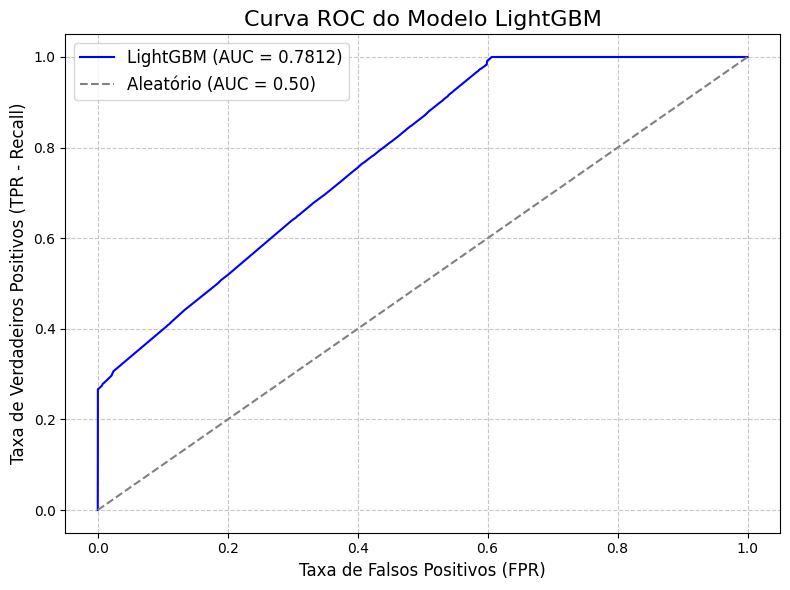

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns

# ... (Seu código de treinamento e predição do modelo) ...
# y_test e y_proba (probabilidades da classe 1) devem estar definidos

# Calcular ROC curve e AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

# Plotar Curva ROC
plt.figure(figsize=(8, 6))
sns.lineplot(x=fpr, y=tpr, label=f'LightGBM (AUC = {auc_score:.4f})', color='blue')
sns.lineplot(x=[0, 1], y=[0, 1], linestyle='--', label='Aleatório (AUC = 0.50)', color='gray')

plt.title('Curva ROC do Modelo LightGBM', fontsize=16)
plt.xlabel('Taxa de Falsos Positivos (FPR)', fontsize=12)
plt.ylabel('Taxa de Verdadeiros Positivos (TPR - Recall)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

### 2. O Que o Modelo Aprendeu? Foco no Comportamento

Este gráfico de barras mostra quais variáveis o modelo considera mais importantes para tomar sua decisão de risco. O foco do modelo agora está onde ele deveria estar: no comportamento recente do cliente, e não em características estáticas.

scr_tcr_implicita (Dívida Total vs. Renda Presumida): É a variável mais importante. Isso significa que a dívida total que o cliente está acumulando, em relação ao que presumimos ser sua renda, é o sinal mais forte de que o cliente entrará em dificuldades.

gasto_crescim_3m & scr_crescim_divida_3m (Crescimento): O modelo valoriza muito a trajetória. Um aumento rápido no uso do cartão e na dívida total nos últimos 3 meses é um alarme vermelho muito claro.

O modelo ignora características irrelevantes (como Região ou Idade), focando 100% nas tendências financeiras da vida do cliente.

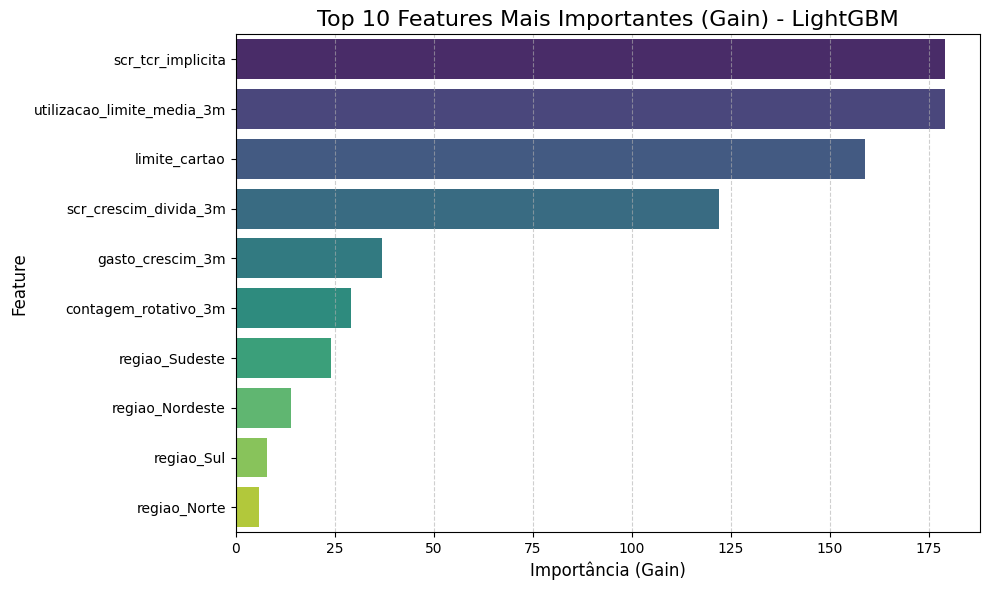

In [13]:
# O DataFrame feature_imp deve ter sido calculado na seção anterior:
# feature_imp = pd.DataFrame({'feature': X_train.columns, 'importance': lgbm.feature_importances_})
# feature_imp = feature_imp.sort_values(by='importance', ascending=False)

# Selecionar o Top 10 para visualização
top_n = 10
df_plot = feature_imp.head(top_n)

plt.figure(figsize=(10, 6))
# Usamos seaborn para um estilo de barra mais agradável
sns.barplot(x='importance', y='feature', data=df_plot, palette='viridis')

plt.title(f'Top {top_n} Features Mais Importantes (Gain) - LightGBM', fontsize=16)
plt.xlabel('Importância (Gain)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### 3. O Impacto Financeiro: Capturando o Risco no Momento Certo

Esta matriz mostra os resultados de nossas previsões no período de teste (Meses 18 a 23), usando o threshold ideal de $0.20$ para maximizar o Recall (captura de risco).

- Verdadeiros Positivos (TP - Nossos Acertos): Clientes que iriam entrar no Rotativo e que nosso modelo identificou corretamente. Este é o grupo que vamos abordar com a Oferta de Parcelamento antes que o rotativo aconteça. Isso representa o risco evitado e a receita retida.

- Falsos Positivos (FP - Nosso Custo): Clientes que não iriam entrar no Rotativo, mas que foram classificados como risco. É o custo de abordar um cliente desnecessariamente. Nosso objetivo é manter este número o mais baixo possível, sem perder a captura de risco (TP).

O equilíbrio atual maximiza a captura de clientes de risco (TP), permitindo que a área de Negócio possa agir preventivamente.

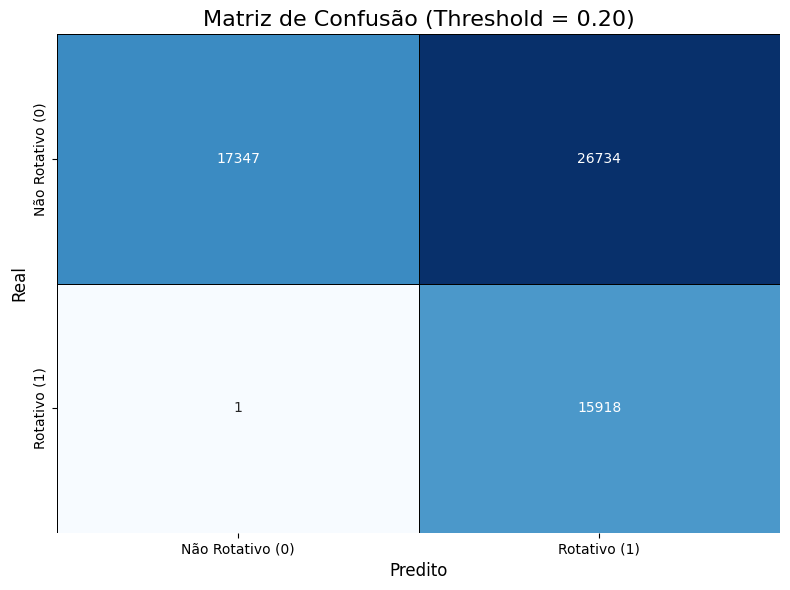

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# O y_test (valores reais) e y_pred (predição com threshold 0.20) já devem estar definidos
# THRESHOLD_OTIMIZADO = 0.20 
# y_pred = (y_proba >= THRESHOLD_OTIMIZADO).astype(int)

# Calcular a Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)

# Nomes das classes
labels = ['Não Rotativo (0)', 'Rotativo (1)']

plt.figure(figsize=(8, 6))
# Cria o heatmap
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    xticklabels=labels, 
    yticklabels=labels,
    cbar=False, # Não precisamos da barra de cor lateral
    linewidths=.5, # Adiciona linhas para melhor separação
    linecolor='black'
)

plt.title(f'Matriz de Confusão (Threshold = {THRESHOLD_OTIMIZADO:.2f})', fontsize=16)
plt.xlabel('Predito', fontsize=12)
plt.ylabel('Real', fontsize=12)
plt.tight_layout()
plt.show()